In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from hmmlearn import hmm

startprob_: [0.33333333 0.33333333 0.33333333]
transmat_:
[[0.   0.5  0.5 ]
 [0.5  0.25 0.25]
 [0.5  0.25 0.25]]
emissionprob_:
[[0.1  0.2  0.4  0.3 ]
 [0.15 0.25 0.5  0.1 ]
 [0.2  0.3  0.4  0.1 ]]


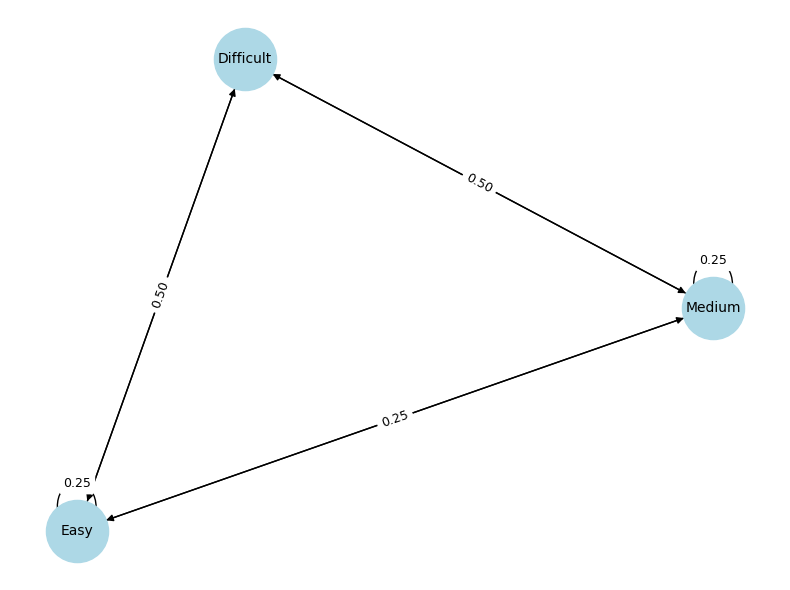

In [7]:
# a)

states = ["Difficult", "Medium", "Easy"]
n_components = len(states)
observations_labels = ["FB", "B", "S", "NS"]
n_observations = len(observations_labels)

startp = np.array([1/3, 1/3, 1/3])

tp = np.array([
    [0.0, 0.5, 0.5],    # din d 0%, din m 50%, din e 50%
    [0.5, 0.25, 0.25],  # din d 50%, din m 25%, din e 25%
    [0.5, 0.25, 0.25],  # din d 50%, din m 25%, din e 25%
])

ep = np.array([
    [0.1, 0.2, 0.4, 0.3], # daca d -> FB 10%, B 20%, S 40%, NS 30%
    [0.15, 0.25, 0.5, 0.1], # daca m -> FB 15%, B 25%, S 50%, NS 10%
    [0.2, 0.3, 0.4, 0.1],   # daca e -> FB 20%, B 30%, S 40%, NS 10%
])

model = hmm.CategoricalHMM(n_components)
model.startprob_ = startp
model.transmat_ = tp
model.emissionprob_ = ep

print("startprob_:", model.startprob_)
print("transmat_:")
print(model.transmat_)
print("emissionprob_:")
print(model.emissionprob_)


out_dir = os.path.join(os.path.dirname("."), 'outputs')
os.makedirs(out_dir, exist_ok=True)

G = nx.DiGraph()
for s in states:
    G.add_node(s)
for i, a in enumerate(states):
    for j, b in enumerate(states):
        prob = tp[i][j]
        if prob > 0:
            G.add_edge(a, b, weight=prob)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos, node_color='lightblue', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.axis('off')
plt.tight_layout()
save = os.path.join(out_dir, 'hmm_states.png')
plt.savefig(save, dpi=200, bbox_inches='tight')

In [8]:
# b)

observed_grades = ["FB", "FB", "S", "B", "B", "S", "B", "B", "NS", "B", "B"]
grade_to_index = {"FB": 0, "B": 1, "S": 2, "NS": 3}
observations_sequence = [grade_to_index[g] for g in observed_grades]

def forward_scaled(observations, startp, tp, ep):
    T = len(observations)
    N = len(startp)
    alpha = np.zeros((T, N))
    scales = np.zeros(T)

    
    alpha[0] = startp * ep[:, observations[0]]
    scales[0] = alpha[0].sum()
    if scales[0] == 0:
        scales[0] = 1e-300
    alpha[0] /= scales[0]

    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ tp) * ep[:, observations[t]]
        scales[t] = alpha[t].sum()
        if scales[t] == 0:
            scales[t] = 1e-300
        alpha[t] /= scales[t]

    log_prob = np.sum(np.log(scales))
    prob = np.exp(log_prob)
    return prob, log_prob, alpha

prob, logp, alpha = forward_scaled(observations_sequence, startp, tp, ep)

print(f"Sequence: {' -> '.join(observed_grades)}")
print(f"P(O): {prob:.6e}")
print(f"Log-probability: {logp:.6f}")

Sequence: FB -> FB -> S -> B -> B -> S -> B -> B -> NS -> B -> B
P(O): 1.688815e-07
Log-probability: -15.594069
